In [5]:
subset.countries.unique()

array([141.,  nan,  93., 199.,  98., 163.], dtype=float32)

In [ ]:
# country <> continent table
# https://gist.githubusercontent.com/stevewithington/20a69c0b6d2ff846ea5d35e5fc47f26c/raw/13716ceb2f22b5643ce5e7039643c86a0e0c6da6/country-and-continent-codes-list-csv.csv
continents = pd.read_csv("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/raw/continents/continents.csv")
# country <> id table
import json
with open("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_2/gadm/country_code_mapping.json", "r") as file:
    ids = json.load(file)
# list of ids for Africa
africa = continents.query("Continent_Code=='AF'").Three_Letter_Country_Code.map(ids).tolist()

In [ ]:
# Hodler & Raschky, 2014 countries
countries = [
    "Afghanistan", "Albania", "Algeria", "Angola", "Argentina", "Australia",
    "Austria", "Bangladesh", "Belarus", "Belgium", "Benin", "Bhutan", "Bolivia", "Bosnia and Herzegovina",
    "Botswana", "Brazil", "Bulgaria", "Burkina Faso", "Burundi", "Cambodia", "Cameroon", "Canada",
    "Central African Republic", "Chad", "Chile", "China", "Colombia", "Costa Rica", "Czechia",
    "Côte d'Ivoire", "Democratic Republic of the Congo", "Denmark", "Timor-Leste", "Ecuador", "El Salvador",
    "Eritrea", "Ethiopia", "Fiji", "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany",
    "Ghana", "Greece", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "India", "Indonesia",
    "Iran", "Iraq", "Italy", "Japan", "Jordan", "Kazakhstan", "Kenya", "Laos", "Latvia", "Lebanon",
    "Liberia", "Lithuania", "North Macedonia", "Madagascar", "Malawi", "Malaysia", "Mali", "Mauritania", "México",
    "Mongolia", "Morocco", "Mozambique", "Myanmar", "Namibia", "Nepal", "Netherlands", "New Zealand",
    "Nicaragua", "Niger", "Nigeria", "North Korea", "Norway", "Oman", "Pakistan", "Panama",
    "Papua New Guinea", "Paraguay", "Peru", "Philippines", "Poland", "Portugal", "Republic of the Congo",
    "Russia", "Rwanda", "Senegal", "Serbia", "Sierra Leone", "Slovakia", "Slovenia", "Somalia", "South Africa",
    "South Korea", "Spain", "Sri Lanka", "Sudan", "Sweden", "Taiwan", "Tajikistan", "Tanzania", "Thailand",
    "Togo", "Tunisia", "Uganda", "Ukraine", "United Kingdom", "United States", "Uruguay", "Venezuela",
    "Vietnam", "Yemen", "Zambia", "Zimbabwe"
]

# country name <> country iso3 table 
import geopandas as gpd
gadm = gpd.read_file("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_1/gadm/gadm_levelADM_0_simplified.gpkg").drop(columns=["geometry"])
gadm = gadm.set_index("COUNTRY").to_dict()["GID_0"]

# country <> id table
import json
with open("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_2/gadm/country_code_mapping.json", "r") as file:
    ids = json.load(file)

# list of IDs for Hodler & Raschky, 2014
countries = [ids[gadm[x]] for x in countries]

In [ ]:
m = compressed_ols(
    formula="log(ntl_harm + 0.01) ~ reg_fav | pixel_id + year | 0 | country",
    data="/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/assembled/5km.parquet",
    n_bootstraps=99,
    round_strata=5,
    seed=42,
    fe_method="mundlak",
    duckdb_kwargs={
        "temp_directory": "/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/assembled/scratch/duckdb_swap",
        "memory_limit": "48GB",
        "max_temp_directory_size": "1024GB",
        "enable_progress_bar": "true"
        },
)
results = m.summary()
restab = pd.DataFrame(
    np.c_[results["point_estimate"], results["standard_error"]],
    columns=["point_estimate", "standard_error"],
)
restab

---

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from itertools import product
import matplotlib.pyplot as plt

In [2]:
hr2014_countries = [
            "Afghanistan", "Albania", "Algeria", "Angola", "Argentina", "Australia",
            "Austria", "Bangladesh", "Belarus", "Belgium", "Benin", "Bhutan", "Bolivia", "Bosnia and Herzegovina",
            "Botswana", "Brazil", "Bulgaria", "Burkina Faso", "Burundi", "Cambodia", "Cameroon", "Canada",
            "Central African Republic", "Chad", "Chile", "China", "Colombia", "Costa Rica", "Czechia",
            "Côte d'Ivoire", "Democratic Republic of the Congo", "Denmark", "Timor-Leste", "Ecuador", "El Salvador",
            "Eritrea", "Ethiopia", "Fiji", "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany",
            "Ghana", "Greece", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "India", "Indonesia",
            "Iran", "Iraq", "Italy", "Japan", "Jordan", "Kazakhstan", "Kenya", "Laos", "Latvia", "Lebanon",
            "Liberia", "Lithuania", "North Macedonia", "Madagascar", "Malawi", "Malaysia", "Mali", "Mauritania", "México",
            "Mongolia", "Morocco", "Mozambique", "Myanmar", "Namibia", "Nepal", "Netherlands", "New Zealand",
            "Nicaragua", "Niger", "Nigeria", "North Korea", "Norway", "Oman", "Pakistan", "Panama",
            "Papua New Guinea", "Paraguay", "Peru", "Philippines", "Poland", "Portugal", "Republic of the Congo",
            "Russia", "Rwanda", "Senegal", "Serbia", "Sierra Leone", "Slovakia", "Slovenia", "Somalia", "South Africa",
            "South Korea", "Spain", "Sri Lanka", "Sudan", "Sweden", "Taiwan", "Tajikistan", "Tanzania", "Thailand",
            "Togo", "Tunisia", "Uganda", "Ukraine", "United Kingdom", "United States", "Uruguay", "Venezuela",
            "Vietnam", "Yemen", "Zambia", "Zimbabwe"
        ]

In [3]:
adm_1 = gpd.read_file("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_1/gadm/gadm_levelADM_1_simplified.gpkg")
adm_1["geometry"] = adm_1["geometry"].simplify(.1, preserve_topology=False)
adm_2 = gpd.read_file("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_1/gadm/gadm_levelADM_2_simplified.gpkg")
adm_2["geometry"] = adm_2["geometry"].simplify(.1, preserve_topology=False)

In [4]:
adm_2_comp = gpd.read_file("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/scratch/geoBoundariesCGAZ_ADM2/geoBoundariesCGAZ_ADM2.shp")
adm_2_comp["geometry"] = adm_2_comp["geometry"].simplify(.1, preserve_topology=False)
adm_2_comp["country"] = adm_2_comp.shapeGroup.map(adm_2.set_index("GID_0")["COUNTRY"].to_dict())

In [5]:
adm_2

,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.1_1,Baharak,NA,NA,Wuleswali,District,NA,AF.BD.BA,"POLYGON ((71.41149 36.55717, 71.1881 36.48441,..."
1,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.2_1,Darwaz,NA,NA,Wuleswali,District,NA,AF.BD.DA,"POLYGON ((71.2762 38.00465, 70.41838 38.08248,..."
2,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.3_1,Fayzabad,NA,NA,Wuleswali,District,NA,AF.BD.FA,"POLYGON ((70.86099 37.15163, 70.65963 36.99236..."
3,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.4_1,Ishkashim,NA,NA,Wuleswali,District,NA,AF.BD.IK,"POLYGON ((71.21882 36.77991, 71.39261 36.98609..."
4,AFG,Afghanistan,AFG.1_1,Badakhshan,NA,AFG.1.5_1,Jurm,NA,NA,Wuleswali,District,NA,AF.BD.JU,"POLYGON ((70.71236 37.07621, 70.99757 36.9066,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47212,ZWE,Zimbabwe,ZWE.10_1,Midlands,NA,ZWE.10.10_2,Redcliff,NA,NA,District,District,NA,NA,MULTIPOLYGON EMPTY
47213,ZWE,Zimbabwe,ZWE.10_1,Midlands,NA,ZWE.10.11_2,Shurugwi,NA,NA,District,District,NA,NA,"POLYGON ((29.8756 -20.0057, 29.85595 -19.55035..."
47214,ZWE,Zimbabwe,ZWE.10_1,Midlands,NA,ZWE.10.12_2,Shurugwi Town,NA,NA,District,District,NA,NA,MULTIPOLYGON EMPTY
47215,ZWE,Zimbabwe,ZWE.10_1,Midlands,NA,ZWE.10.13_2,Zvishavane,NA,NA,District,District,NA,NA,"POLYGON ((30.44969 -20.62483, 29.80169 -20.365..."


<Axes: >

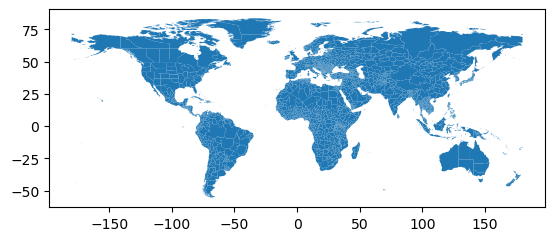

In [21]:
adm_1.plot()

<Axes: >

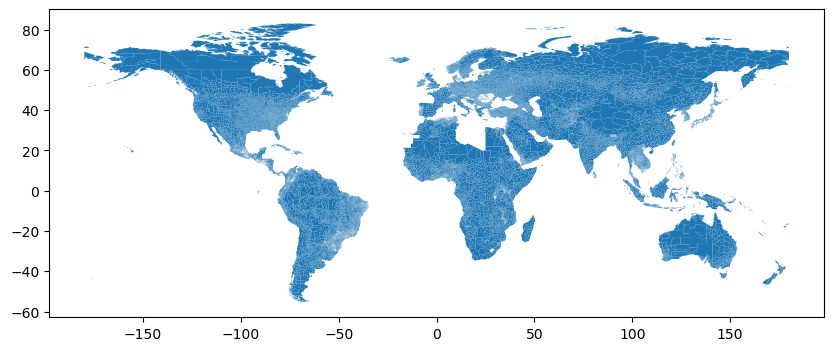

In [16]:
fix, ax = plt.subplots(figsize=(10,5))
adm_2.plot(ax=ax)

In [8]:
for country in hr2014_countries:
    if adm_2[adm_2.COUNTRY == country].shape[0] == 0:
        print(f"Problem at country {country}")

Problem at country North Macedonia


In [4]:
adm_2.shape[0]

47217

<Axes: >

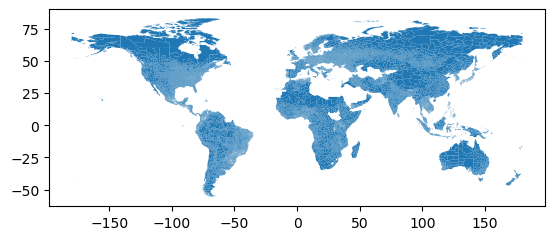

In [28]:
adm_2[(adm_2.COUNTRY.isin(hr2014_countries))].plot()

In [25]:
adm_2[((adm_2.COUNTRY.isin(hr2014_countries)) & (adm_2.bounds.miny < 65))].shape[0]

27941

In [8]:
adm_2_comp[((adm_2_comp.country.isin(hr2014_countries)) & (adm_2_comp.bounds.miny < 65))].shape[0]

29253

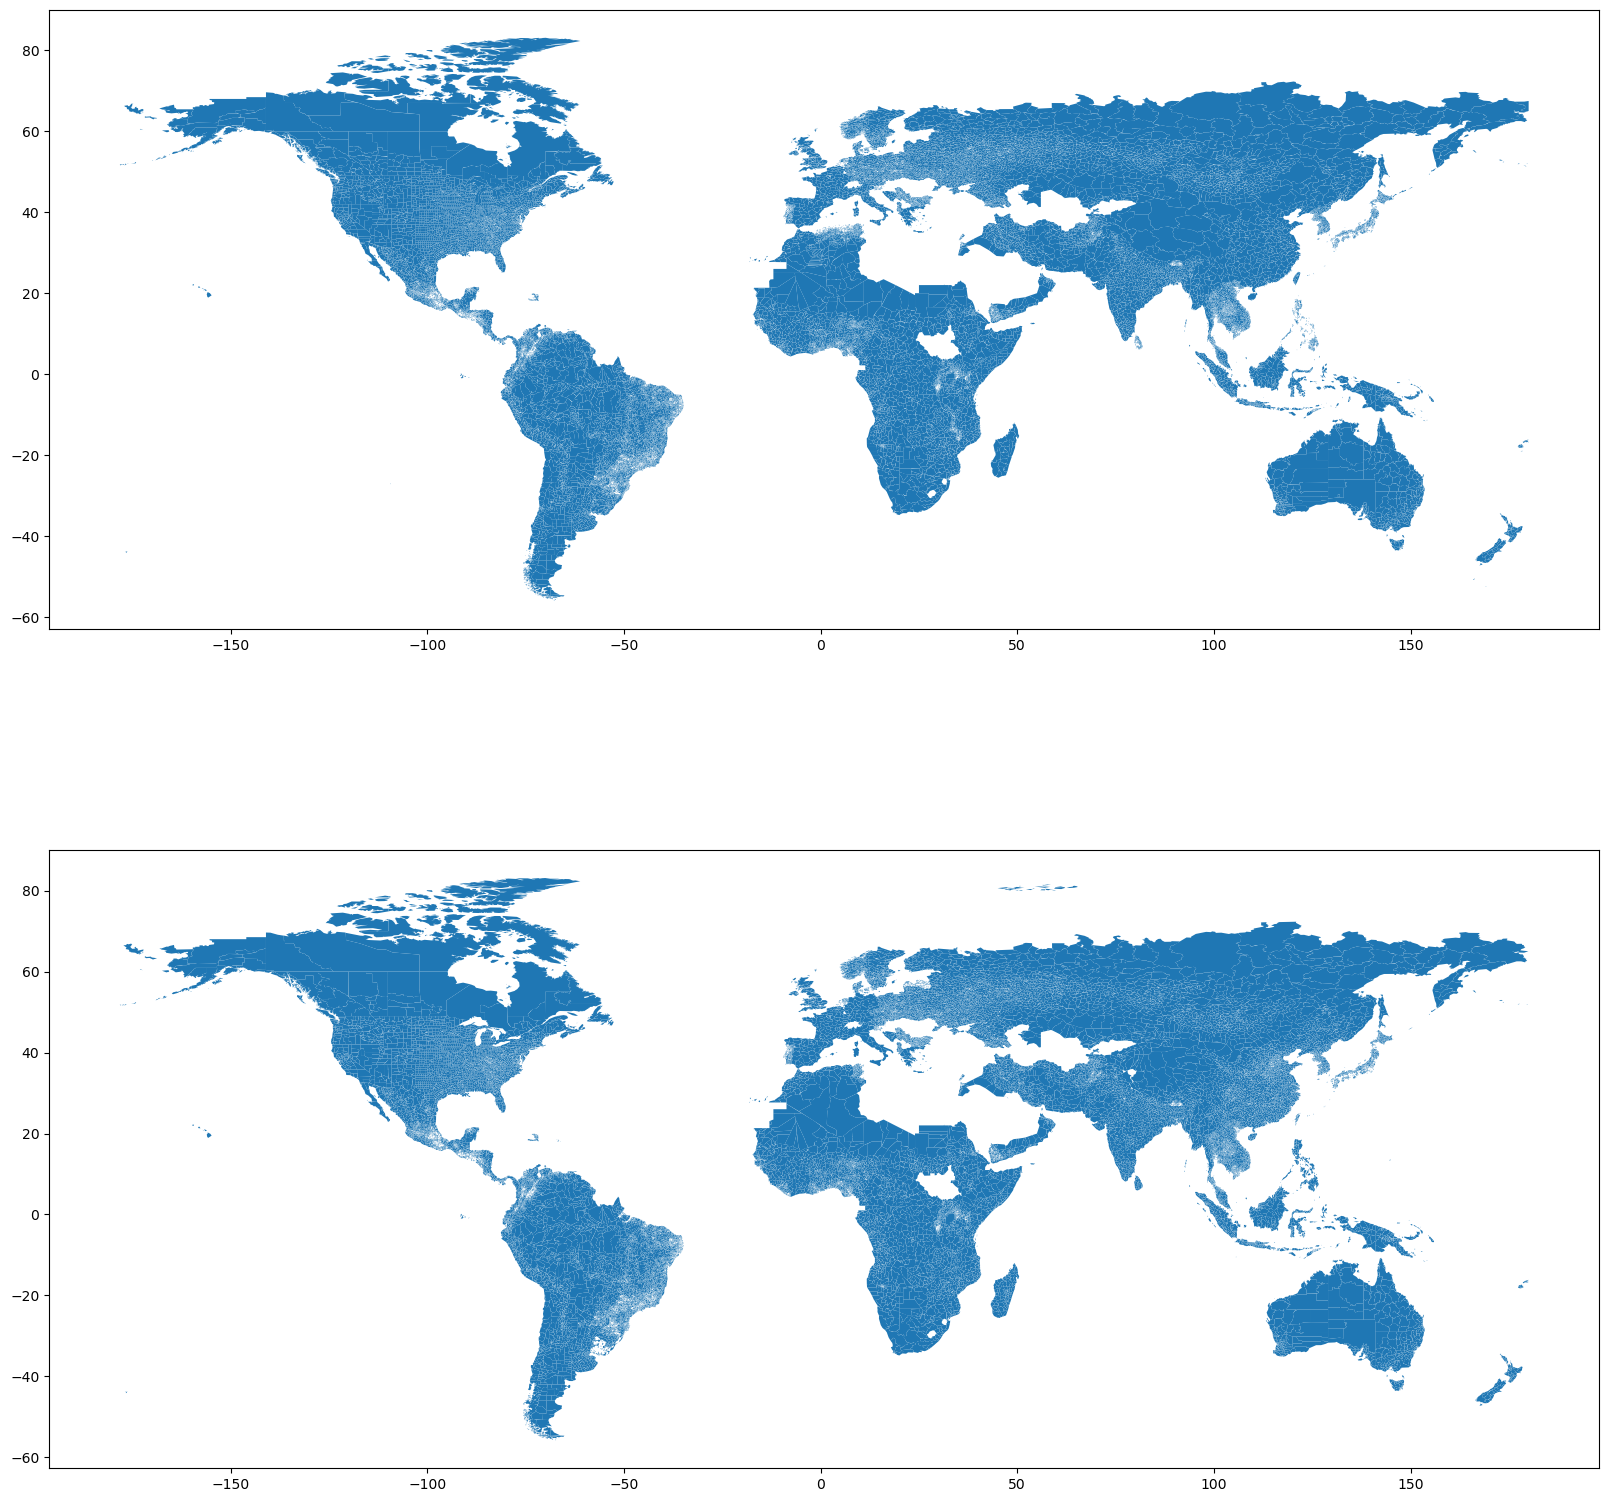

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(20,20))

adm_2[((adm_2.COUNTRY.isin(hr2014_countries)) & (adm_2.bounds.miny < 65))].plot(ax=ax[0])
adm_2_comp[((adm_2_comp.country.isin(hr2014_countries)) & (adm_2_comp.bounds.miny < 65))].plot(ax=ax[1])

fig.savefig("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/gnt/experiments/test.png", dpi=300)